In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import random

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat_trainmode import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import editdistance

def compute_edit_distance(seqs, opt_len=None) :
    shuffle_index = np.arange(len(seqs))
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)
    
    seqs_shuffled = [seqs[shuffle_index[i]] for i in range(len(seqs))]
    edit_distances = np.ravel([float(editdistance.eval(seq_1, seq_2)) for seq_1, seq_2 in zip(seqs, seqs_shuffled)])
    if opt_len is not None :
        edit_distances /= opt_len
    
    return edit_distances


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_isoform_loss(target_isos, isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    entropy_anneal_coeff = K.variable(0.)
    entropy_anneal_func = lambda alpha, epoch: 1. # - 0.95 ** epoch
    
    target_iso = np.zeros((len(target_isos), 1))
    for i, t_iso in enumerate(target_isos) :
        target_iso[i, 0] = t_iso
    
    masked_use_entropy_mse = get_target_entropy_sme_masked(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    masked_dse_entropy_mse = get_target_entropy_sme_masked(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=70-60, pwm_end=76+60, margin=similarity_margin, shift_1_nt=True)
    
    extra_sim = np.ones((len(target_isos), 1, 205, 4, 1))
    for i in range(len(target_isos)) :
        extra_sim[i, 0, 70-4:76, :, 0] = 0.0
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_anneal_coeff * entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask), axis=1)
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    def val_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * symmetric_sigmoid_kl_divergence(iso_true, iso_pred)[:, 0, ...]
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * punish_dn_cse_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_c * punish_up_c_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_c * punish_dn_c_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_g * punish_up_g_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_g * punish_dn_g_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_aa * punish_up_aa_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_aa * punish_dn_aa_func(sampled_pwm_1)[:, 0, ...]
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_anneal_coeff * entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask)[:, 0, ...]
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    def val_loss_func_noentropy(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * symmetric_sigmoid_kl_divergence(iso_true, iso_pred)[:, 0, ...]
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * punish_dn_cse_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_c * punish_up_c_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_c * punish_dn_c_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_g * punish_up_g_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_g * punish_dn_g_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_aa * punish_up_aa_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_aa * punish_dn_aa_func(sampled_pwm_1)[:, 0, ...]
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = similarity_weight * pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask)[:, 0, ...]
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    def val_loss_func_onlyisoform(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        #iso_loss = 2.0 * symmetric_sigmoid_kl_divergence(iso_true, iso_pred)[:, 0, ...]
        iso_loss = -1.0 * iso_score_pred
        
        #Compute total loss
        total_loss = iso_loss

        return total_loss
    
    return loss_func, val_loss_func, val_loss_func_noentropy, val_loss_func_onlyisoform, entropy_anneal_coeff, entropy_anneal_func


In [3]:

#Sequence optimization monitor during training
class GenesisMonitor(Callback):
    def __init__(self, generator_model, sequence_encoder, run_dir="", run_prefix="", val_steps=1, batch_size=32) :
        self.generator_model = generator_model
        self.batch_size = batch_size
        self.val_steps = val_steps
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        self.edit_distance_samples = []
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        self._store_sequences(seqs, 0)
        self._compute_edit_distances(seqs, 0)
    
    def _sample_sequences(self) :
        gen_bundle = self.generator_model.predict(x=None, steps=self.val_steps)
        _, _, _, _, _, sampled_pwm, _, _, _ = gen_bundle
        
        seqs = [
            self.sequence_encoder.decode(sampled_pwm[i, 0, :, :, 0]) for i in range(sampled_pwm.shape[0])
        ]
        
        return seqs
    
    def _compute_edit_distances(self, seqs, epoch) :
        
        edit_dists = compute_edit_distance(seqs)
        self.edit_distance_samples.append(edit_dists.reshape(1, -1))
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.val_steps) + "_steps.txt", "wt") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_epoch_end(self, epoch, logs={}) :
        
        seqs = self._sample_sequences()
        self._store_sequences(seqs, epoch)
        self._compute_edit_distances(seqs, epoch)

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps))
    
    def on_epoch_end(self, epoch, logs={}) :
        #Track val loss
        
        val_loss_values = self.val_loss_model.predict(x=None, steps=self.val_steps)
        
        self.val_loss_history.append(val_loss_values)
        
        print("mean(" + self.val_name + ") = " + str(np.mean(val_loss_values)))

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(run_prefix, sequence_templates, loss_funcs, library_contexts, batch_size=32, sample_mode='pwm', n_samples=1, n_epochs=10, steps_per_epoch=100, val_steps=100, normalize_logits=False) :
    
    loss_func, val_loss_func, val_loss_func_noentropy, val_loss_func_onlyisoform, entropy_anneal_coeff, entropy_anneal_func = loss_funcs
    
    if sample_mode == 'both' :
        return _run_both_genesis(run_prefix, sequence_templates, loss_funcs, library_contexts, batch_size, n_samples, n_epochs, steps_per_epoch, val_steps)
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=normalize_logits, validation_sample_mode='sample')

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode=sample_mode)
    _, val_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')
    for layer in val_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_valversion"

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(predictor, loss_func)
    
    _, val_loss_model = build_loss_model(val_predictor, val_loss_func)
    _, val_loss_noentropy_model = build_loss_model(val_predictor, val_loss_func_noentropy)
    _, val_loss_onlyisoform_model = build_loss_model(val_predictor, val_loss_func_onlyisoform)
    

    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    validation_history = ValidationCallback('val_loss', val_loss_model, val_steps)
    validation_noentropy_history = ValidationCallback('val_loss_no_entropy', val_loss_noentropy_model, val_steps)
    validation_onlyisoform_history = ValidationCallback('val_loss_only_isoform', val_loss_onlyisoform_model, val_steps)
    
    #Standard sequence decoder
    acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
    
    #Build callback for printing intermediate sequences
    genesis_monitor = GenesisMonitor(generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", val_steps=val_steps, batch_size=batch_size)
    
    #Specify callback entities
    callbacks =[
        EpochVariableCallback(entropy_anneal_coeff, entropy_anneal_func),
        validation_history,
        validation_noentropy_history,
        validation_onlyisoform_history,
        genesis_monitor
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )
    
    validation_history_dict = {
        'val_name' : validation_history.val_name,
        'val_loss_history' : validation_history.val_loss_history
    }
    validation_history.val_loss_model = None
    
    validation_noentropy_history_dict = {
        'val_name' : validation_noentropy_history.val_name,
        'val_loss_history' : validation_noentropy_history.val_loss_history
    }
    validation_noentropy_history.val_loss_model = None
    
    validation_onlyisoform_history_dict = {
        'val_name' : validation_onlyisoform_history.val_name,
        'val_loss_history' : validation_onlyisoform_history.val_loss_history
    }
    validation_onlyisoform_history.val_loss_model = None
    
    edit_distance_dict = {
        'edit_distance_samples' : genesis_monitor.edit_distance_samples
    }
    genesis_monitor.generator_model = None

    return generator, predictor, train_history, [validation_history_dict, validation_noentropy_history_dict, validation_onlyisoform_history_dict, edit_distance_dict]


def _run_both_genesis(run_prefix, sequence_templates, loss_funcs, library_contexts, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100, val_steps=100, normalize_logits=False) :
    
    loss_func, val_loss_func, val_loss_func_noentropy, val_loss_func_onlyisoform, entropy_anneal_coeff, entropy_anneal_func = loss_funcs
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=normalize_logits, validation_sample_mode='sample')

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')
    for layer in pwm_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_pwmversion"
    _, val_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')
    for layer in val_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_valversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    _, val_loss_model = build_loss_model(val_predictor, val_loss_func)
    _, val_loss_noentropy_model = build_loss_model(val_predictor, val_loss_func_noentropy)
    _, val_loss_onlyisoform_model = build_loss_model(val_predictor, val_loss_func_onlyisoform)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    validation_history = ValidationCallback('val_loss', val_loss_model, val_steps)
    validation_noentropy_history = ValidationCallback('val_loss_no_entropy', val_loss_noentropy_model, val_steps)
    validation_onlyisoform_history = ValidationCallback('val_loss_only_isoform', val_loss_onlyisoform_model, val_steps)
    
    #Standard sequence decoder
    acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
    
    #Build callback for printing intermediate sequences
    genesis_monitor = GenesisMonitor(generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", val_steps=val_steps, batch_size=batch_size)
    
    #Specify callback entities
    callbacks =[
        EpochVariableCallback(entropy_anneal_coeff, entropy_anneal_func),
        validation_history,
        validation_noentropy_history,
        validation_onlyisoform_history,
        genesis_monitor
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )

    validation_history_dict = {
        'val_name' : validation_history.val_name,
        'val_loss_history' : validation_history.val_loss_history
    }
    validation_history.val_loss_model = None
    
    validation_noentropy_history_dict = {
        'val_name' : validation_noentropy_history.val_name,
        'val_loss_history' : validation_noentropy_history.val_loss_history
    }
    validation_noentropy_history.val_loss_model = None
    
    validation_onlyisoform_history_dict = {
        'val_name' : validation_onlyisoform_history.val_name,
        'val_loss_history' : validation_onlyisoform_history.val_loss_history
    }
    validation_onlyisoform_history.val_loss_model = None
    
    edit_distance_dict = {
        'edit_distance_samples' : genesis_monitor.edit_distance_samples
    }
    genesis_monitor.generator_model = None

    return generator, sample_predictor, train_history, [validation_history_dict, validation_noentropy_history_dict, validation_onlyisoform_history_dict, edit_distance_dict]


In [4]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)

In [5]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple'
]

target_isos = [
    1.0
]



In [6]:
def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

In [7]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS (Max Isoform)")

#Sampling conditions to evaluate
sampling_conds = [
    ['pwm', 1, False],
    ['sample', 1, False],
    ['sample', 10, False],
    ['both', 1, False],
    ['both', 10, False]
]

#Number of PWMs to generate per objective
batch_size = 32

#Number of epochs per objective to optimize
n_epochs = 100

#Number of steps (grad updates) per epoch
steps_per_epoch = 50

#Number of validation steps
val_steps = 50

#Number of independent trial runs
n_runs = 5

seeds = [51125, 222842, 325484, 475737, 727322]

for sampling_cond_ix, sampling_cond in enumerate(sampling_conds) :
    print("Sampling mode = '" + str(sampling_cond[0]) + "', n_samples = '" + str(sampling_cond[1]) + "'")

    if len(sampling_cond) <= 3 :
    
        sampling_dict = {'train' : [], 'val' : []}
        sampling_cond.append(sampling_dict)

        for run_ix in range(n_runs) :

            K.clear_session()

            set_seed(seeds[run_ix])

            losses = get_isoform_loss(
                target_isos,
                use_start=22,
                use_end=70,
                use_target_bits=1.95,
                cse_start=70,
                cse_end=76,
                cse_target_bits=1.95,
                dse_start=76,
                dse_end=121,
                dse_target_bits=1.95,
                entropy_weight=1.0,
                similarity_weight=5.0,
                similarity_margin=0.5,
                punish_dn_cse=1.0,
                punish_up_c=0.0015,
                punish_dn_c=0.0001,
                punish_up_g=0.0001,
                punish_dn_g=0.0001,
                punish_up_aa=0.00025,
                punish_dn_aa=0.005
            )
            
            run_prefix = "genesis_apa_max_isoform_simple_eval_sampling_modes_longtrain_cond_" + str(sampling_cond_ix) + "_run_" + str(run_ix)

            genesis_generator, genesis_predictor, train_history, validation_histories = run_genesis(run_prefix, sequence_templates, losses, library_contexts, batch_size, sampling_cond[0], sampling_cond[1], n_epochs, steps_per_epoch, val_steps, sampling_cond[2])

            sampling_dict['train'].append(train_history.history)
            sampling_dict['val'].append(validation_histories)


Training GENESIS (Max Isoforms of All libraries)
Sampling mode = 'pwm', n_samples = '1'


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/100
50/50 [==============================] - 3s 65ms/step - loss: 5.7403
mean(val_loss) = 8.83426
mean(val_loss_no_entropy) = 7.613746
mean(val_loss_only_isoform) = -1.3894941
Epoch 2/100
50/50 [==============================] - 1s 15ms/step - loss: 2.5414
mean(val_loss) = 6.4476094
mean(val_loss_no_entropy) = 6.06897
mean(val_loss_only_isoform) = -1.8551425
Epoch 3/100
50/50 [==============================] - 1s 15ms/step - loss: 2.1496
mean(val_loss) = 6.035426
mean(val_loss_no_entropy) = 5.7990613
mean(val_loss_only_isoform) = -1.9256133
Epoch 4/100
50/50 [==============================] - 1s 15ms/step - loss: 2.1063
mean(val_loss) = 6.151461
mean(val_loss_no_entropy) = 6.0200105
mean(val_loss_only_isoform) = -1.8819404
Epoch 5/100
50/50 [==============================] - 1s 15ms/step - loss: 2.0669
mean(val_loss) = 4.32701
mean(val_loss_no_entropy) = 4.233659
mean(val_loss_only_isoform) = -2.431745
Epoch 6/100
50/50 [==============================] - 1s 15ms/step - loss: 1.

mean(val_loss_no_entropy) = 0.09805261
mean(val_loss_only_isoform) = -6.694271
Epoch 45/100
50/50 [==============================] - 1s 25ms/step - loss: 0.1085
mean(val_loss) = 0.11706461
mean(val_loss_no_entropy) = 0.09660669
mean(val_loss_only_isoform) = -6.8183937
Epoch 46/100
50/50 [==============================] - 1s 25ms/step - loss: 0.1069
mean(val_loss) = 0.10892077
mean(val_loss_no_entropy) = 0.09140549
mean(val_loss_only_isoform) = -6.7833977
Epoch 47/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1099
mean(val_loss) = 0.110745676
mean(val_loss_no_entropy) = 0.104031764
mean(val_loss_only_isoform) = -6.4889855
Epoch 48/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1083
mean(val_loss) = 0.11257488
mean(val_loss_no_entropy) = 0.0921554
mean(val_loss_only_isoform) = -6.7959023
Epoch 49/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0987
mean(val_loss) = 0.10363876
mean(val_loss_no_entropy) = 0.09520009
mean(val_lo

Epoch 88/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0489
mean(val_loss) = 0.055088997
mean(val_loss_no_entropy) = 0.047383774
mean(val_loss_only_isoform) = -7.7362413
Epoch 89/100
50/50 [==============================] - 1s 26ms/step - loss: 0.0500
mean(val_loss) = 0.05601103
mean(val_loss_no_entropy) = 0.050838213
mean(val_loss_only_isoform) = -7.532085
Epoch 90/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0529
mean(val_loss) = 0.05784728
mean(val_loss_no_entropy) = 0.046319798
mean(val_loss_only_isoform) = -7.257932
Epoch 91/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0473
mean(val_loss) = 0.053739738
mean(val_loss_no_entropy) = 0.043674212
mean(val_loss_only_isoform) = -7.5372677
Epoch 92/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0557
mean(val_loss) = 0.06049873
mean(val_loss_no_entropy) = 0.059161816
mean(val_loss_only_isoform) = -7.606178
Epoch 93/100
50/50 [==========================

50/50 [==============================] - 1s 26ms/step - loss: 0.0579
mean(val_loss) = 0.0689447
mean(val_loss_no_entropy) = 0.06356101
mean(val_loss_only_isoform) = -6.862265
Epoch 75/100
50/50 [==============================] - 1s 26ms/step - loss: 0.0477
mean(val_loss) = 0.07029251
mean(val_loss_no_entropy) = 0.0686178
mean(val_loss_only_isoform) = -6.8707213
Epoch 76/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0528
mean(val_loss) = 0.062936604
mean(val_loss_no_entropy) = 0.065499604
mean(val_loss_only_isoform) = -7.0415845
Epoch 77/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0567
mean(val_loss) = 0.07123964
mean(val_loss_no_entropy) = 0.06185246
mean(val_loss_only_isoform) = -6.917267
Epoch 78/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0498
mean(val_loss) = 0.06637388
mean(val_loss_no_entropy) = 0.060144626
mean(val_loss_only_isoform) = -7.001859
Epoch 79/100
50/50 [==============================] - 1s 25ms/ste

50/50 [==============================] - 1s 25ms/step - loss: 0.0773
mean(val_loss) = 0.078920595
mean(val_loss_no_entropy) = 0.07267755
mean(val_loss_only_isoform) = -7.143698
Epoch 61/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0728
mean(val_loss) = 0.078860685
mean(val_loss_no_entropy) = 0.07588472
mean(val_loss_only_isoform) = -7.140134
Epoch 62/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0708
mean(val_loss) = 0.083468266
mean(val_loss_no_entropy) = 0.07329704
mean(val_loss_only_isoform) = -7.4132857
Epoch 63/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0724
mean(val_loss) = 0.08590779
mean(val_loss_no_entropy) = 0.07755634
mean(val_loss_only_isoform) = -7.1307836
Epoch 64/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0784
mean(val_loss) = 0.08377081
mean(val_loss_no_entropy) = 0.0738222
mean(val_loss_only_isoform) = -7.0145335
Epoch 65/100
50/50 [==============================] - 1s 25ms/s

50/50 [==============================] - 1s 24ms/step - loss: 0.0507
mean(val_loss) = 0.064532086
mean(val_loss_no_entropy) = 0.050614458
mean(val_loss_only_isoform) = -7.3345766
Epoch 47/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0549
mean(val_loss) = 0.05855868
mean(val_loss_no_entropy) = 0.050624486
mean(val_loss_only_isoform) = -7.366503
Epoch 48/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0516
mean(val_loss) = 0.058471214
mean(val_loss_no_entropy) = 0.04414978
mean(val_loss_only_isoform) = -7.491876
Epoch 49/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0521
mean(val_loss) = 0.05479818
mean(val_loss_no_entropy) = 0.0465127
mean(val_loss_only_isoform) = -7.4212365
Epoch 50/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0519
mean(val_loss) = 0.058623586
mean(val_loss_no_entropy) = 0.053021606
mean(val_loss_only_isoform) = -7.312637
Epoch 51/100
50/50 [==============================] - 1s 24ms

50/50 [==============================] - 1s 24ms/step - loss: 0.0428
mean(val_loss) = 0.04614595
mean(val_loss_no_entropy) = 0.03626366
mean(val_loss_only_isoform) = -7.7637367
Epoch 90/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0407
mean(val_loss) = 0.040008318
mean(val_loss_no_entropy) = 0.03574164
mean(val_loss_only_isoform) = -7.6754856
Epoch 91/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0421
mean(val_loss) = 0.045160577
mean(val_loss_no_entropy) = 0.036608227
mean(val_loss_only_isoform) = -7.5703554
Epoch 92/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0403
mean(val_loss) = 0.042975634
mean(val_loss_no_entropy) = 0.038117625
mean(val_loss_only_isoform) = -7.761898
Epoch 93/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0391
mean(val_loss) = 0.046033267
mean(val_loss_no_entropy) = 0.044733666
mean(val_loss_only_isoform) = -7.470038
Epoch 94/100
50/50 [==============================] - 1s 2

50/50 [==============================] - 1s 24ms/step - loss: 0.0434
mean(val_loss) = 0.05003316
mean(val_loss_no_entropy) = 0.04366883
mean(val_loss_only_isoform) = -7.7878284
Epoch 76/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0464
mean(val_loss) = 0.04473774
mean(val_loss_no_entropy) = 0.04561206
mean(val_loss_only_isoform) = -7.6255565
Epoch 77/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0442
mean(val_loss) = 0.049879618
mean(val_loss_no_entropy) = 0.037817553
mean(val_loss_only_isoform) = -7.704387
Epoch 78/100
50/50 [==============================] - 1s 26ms/step - loss: 0.0446
mean(val_loss) = 0.048414193
mean(val_loss_no_entropy) = 0.04088518
mean(val_loss_only_isoform) = -7.657682
Epoch 79/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0443
mean(val_loss) = 0.049043827
mean(val_loss_no_entropy) = 0.041971475
mean(val_loss_only_isoform) = -7.9224663
Epoch 80/100
50/50 [==============================] - 1s 25m

50/50 [==============================] - 1s 15ms/step - loss: 0.2282
mean(val_loss) = 0.22830199
mean(val_loss_no_entropy) = 0.1987389
mean(val_loss_only_isoform) = -6.3172874
Epoch 19/100
50/50 [==============================] - 1s 19ms/step - loss: 0.1939
mean(val_loss) = 0.2019079
mean(val_loss_no_entropy) = 0.1798841
mean(val_loss_only_isoform) = -6.2790117
Epoch 20/100
50/50 [==============================] - 1s 22ms/step - loss: 0.2053
mean(val_loss) = 0.20293728
mean(val_loss_no_entropy) = 0.17403126
mean(val_loss_only_isoform) = -6.3979244
Epoch 21/100
50/50 [==============================] - 1s 23ms/step - loss: 0.1950
mean(val_loss) = 0.19842657
mean(val_loss_no_entropy) = 0.16526064
mean(val_loss_only_isoform) = -6.26664
Epoch 22/100
50/50 [==============================] - 1s 22ms/step - loss: 0.1807
mean(val_loss) = 0.17932476
mean(val_loss_no_entropy) = 0.1522287
mean(val_loss_only_isoform) = -6.604968
Epoch 23/100
50/50 [==============================] - 1s 23ms/step - l

50/50 [==============================] - 1s 24ms/step - loss: 0.8145
mean(val_loss) = 0.67607087
mean(val_loss_no_entropy) = 0.6091639
mean(val_loss_only_isoform) = -5.530264
Epoch 5/100
50/50 [==============================] - 1s 25ms/step - loss: 0.6065
mean(val_loss) = 0.51189303
mean(val_loss_no_entropy) = 0.41378552
mean(val_loss_only_isoform) = -5.825612
Epoch 6/100
50/50 [==============================] - 1s 26ms/step - loss: 0.4633
mean(val_loss) = 0.4465007
mean(val_loss_no_entropy) = 0.35823116
mean(val_loss_only_isoform) = -5.9511137
Epoch 7/100
50/50 [==============================] - 1s 25ms/step - loss: 0.4195
mean(val_loss) = 0.3837855
mean(val_loss_no_entropy) = 0.32713622
mean(val_loss_only_isoform) = -6.2994456
Epoch 8/100
50/50 [==============================] - 1s 25ms/step - loss: 0.3615
mean(val_loss) = 0.34331897
mean(val_loss_no_entropy) = 0.27377754
mean(val_loss_only_isoform) = -6.149237
Epoch 9/100
50/50 [==============================] - 1s 25ms/step - loss:

50/50 [==============================] - 1s 23ms/step - loss: 0.0538
mean(val_loss) = 0.05108077
mean(val_loss_no_entropy) = 0.0441009
mean(val_loss_only_isoform) = -7.9499874
Epoch 91/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0594
mean(val_loss) = 0.059478693
mean(val_loss_no_entropy) = 0.050583467
mean(val_loss_only_isoform) = -7.751974
Epoch 92/100
50/50 [==============================] - 1s 23ms/step - loss: 0.0572
mean(val_loss) = 0.051512223
mean(val_loss_no_entropy) = 0.044089697
mean(val_loss_only_isoform) = -7.631881
Epoch 93/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0519
mean(val_loss) = 0.05904097
mean(val_loss_no_entropy) = 0.053250924
mean(val_loss_only_isoform) = -8.106867
Epoch 94/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0660
mean(val_loss) = 0.07936529
mean(val_loss_no_entropy) = 0.06893112
mean(val_loss_only_isoform) = -7.7655067
Epoch 95/100
50/50 [==============================] - 1s 25ms/

50/50 [==============================] - 1s 24ms/step - loss: 0.0535
mean(val_loss) = 0.05963418
mean(val_loss_no_entropy) = 0.048030246
mean(val_loss_only_isoform) = -7.961181
Epoch 77/100
50/50 [==============================] - 1s 26ms/step - loss: 0.0467
mean(val_loss) = 0.047495633
mean(val_loss_no_entropy) = 0.046011876
mean(val_loss_only_isoform) = -7.977637
Epoch 78/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0518
mean(val_loss) = 0.05313916
mean(val_loss_no_entropy) = 0.0437078
mean(val_loss_only_isoform) = -8.019076
Epoch 79/100
50/50 [==============================] - 1s 26ms/step - loss: 0.0525
mean(val_loss) = 0.05504865
mean(val_loss_no_entropy) = 0.045444336
mean(val_loss_only_isoform) = -7.7821875
Epoch 80/100
50/50 [==============================] - 1s 26ms/step - loss: 0.0556
mean(val_loss) = 0.052899674
mean(val_loss_no_entropy) = 0.050221976
mean(val_loss_only_isoform) = -7.828574
Epoch 81/100
50/50 [==============================] - 1s 26ms/

50/50 [==============================] - 1s 24ms/step - loss: 0.0587
mean(val_loss) = 0.06313426
mean(val_loss_no_entropy) = 0.058477424
mean(val_loss_only_isoform) = -7.8427444
Epoch 63/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0620
mean(val_loss) = 0.06492499
mean(val_loss_no_entropy) = 0.054916963
mean(val_loss_only_isoform) = -7.9185395
Epoch 64/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0677
mean(val_loss) = 0.06735278
mean(val_loss_no_entropy) = 0.056067504
mean(val_loss_only_isoform) = -7.689342
Epoch 65/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0652
mean(val_loss) = 0.060211603
mean(val_loss_no_entropy) = 0.052816287
mean(val_loss_only_isoform) = -7.724164
Epoch 66/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0633
mean(val_loss) = 0.05907532
mean(val_loss_no_entropy) = 0.047506046
mean(val_loss_only_isoform) = -7.851874
Epoch 67/100
50/50 [==============================] - 1s 25m

50/50 [==============================] - 1s 24ms/step - loss: 0.0823
mean(val_loss) = 0.080483094
mean(val_loss_no_entropy) = 0.06409091
mean(val_loss_only_isoform) = -7.565889
Epoch 49/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0808
mean(val_loss) = 0.091790676
mean(val_loss_no_entropy) = 0.07467978
mean(val_loss_only_isoform) = -7.4810877
Epoch 50/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0868
mean(val_loss) = 0.07732808
mean(val_loss_no_entropy) = 0.06610892
mean(val_loss_only_isoform) = -7.6847405
Epoch 51/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0760
mean(val_loss) = 0.077815145
mean(val_loss_no_entropy) = 0.06534659
mean(val_loss_only_isoform) = -7.5041127
Epoch 52/100
50/50 [==============================] - 1s 23ms/step - loss: 0.0812
mean(val_loss) = 0.083347395
mean(val_loss_no_entropy) = 0.07451274
mean(val_loss_only_isoform) = -7.5460424
Epoch 53/100
50/50 [==============================] - 1s 24m

50/50 [==============================] - 1s 29ms/step - loss: 0.1246
mean(val_loss) = 0.118350334
mean(val_loss_no_entropy) = 0.105627194
mean(val_loss_only_isoform) = -7.0334353
Epoch 35/100
50/50 [==============================] - 1s 30ms/step - loss: 0.1195
mean(val_loss) = 0.12768511
mean(val_loss_no_entropy) = 0.098788224
mean(val_loss_only_isoform) = -6.9276767
Epoch 36/100
50/50 [==============================] - 1s 29ms/step - loss: 0.1156
mean(val_loss) = 0.11323374
mean(val_loss_no_entropy) = 0.10131651
mean(val_loss_only_isoform) = -7.158177
Epoch 37/100
50/50 [==============================] - 1s 29ms/step - loss: 0.1074
mean(val_loss) = 0.10283223
mean(val_loss_no_entropy) = 0.09015639
mean(val_loss_only_isoform) = -6.9316406
Epoch 38/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0949
mean(val_loss) = 0.10153224
mean(val_loss_no_entropy) = 0.08248834
mean(val_loss_only_isoform) = -7.1172256
Epoch 39/100
50/50 [==============================] - 1s 29ms

50/50 [==============================] - 2s 30ms/step - loss: 0.1340
mean(val_loss) = 0.12914962
mean(val_loss_no_entropy) = 0.101413585
mean(val_loss_only_isoform) = -6.9164023
Epoch 21/100
50/50 [==============================] - 2s 30ms/step - loss: 0.1313
mean(val_loss) = 0.13862301
mean(val_loss_no_entropy) = 0.11077323
mean(val_loss_only_isoform) = -7.180997
Epoch 22/100
50/50 [==============================] - 1s 29ms/step - loss: 0.1244
mean(val_loss) = 0.11597057
mean(val_loss_no_entropy) = 0.10429412
mean(val_loss_only_isoform) = -7.0967736
Epoch 23/100
50/50 [==============================] - 1s 29ms/step - loss: 0.1226
mean(val_loss) = 0.11899042
mean(val_loss_no_entropy) = 0.08849659
mean(val_loss_only_isoform) = -7.251222
Epoch 24/100
50/50 [==============================] - 1s 28ms/step - loss: 0.1106
mean(val_loss) = 0.10769157
mean(val_loss_no_entropy) = 0.09170807
mean(val_loss_only_isoform) = -7.2896233
Epoch 25/100
50/50 [==============================] - 1s 29ms/st

50/50 [==============================] - 1s 28ms/step - loss: 0.3675
mean(val_loss) = 0.33638105
mean(val_loss_no_entropy) = 0.31102812
mean(val_loss_only_isoform) = -6.0657277
Epoch 7/100
50/50 [==============================] - 1s 29ms/step - loss: 0.3386
mean(val_loss) = 0.31270897
mean(val_loss_no_entropy) = 0.26902553
mean(val_loss_only_isoform) = -6.098131
Epoch 8/100
50/50 [==============================] - 1s 28ms/step - loss: 0.3093
mean(val_loss) = 0.2955616
mean(val_loss_no_entropy) = 0.25541133
mean(val_loss_only_isoform) = -6.323965
Epoch 9/100
50/50 [==============================] - 1s 27ms/step - loss: 0.2772
mean(val_loss) = 0.24524854
mean(val_loss_no_entropy) = 0.19699383
mean(val_loss_only_isoform) = -6.439637
Epoch 10/100
50/50 [==============================] - 2s 31ms/step - loss: 0.2224
mean(val_loss) = 0.20091625
mean(val_loss_no_entropy) = 0.16176124
mean(val_loss_only_isoform) = -6.693132
Epoch 11/100
50/50 [==============================] - 1s 30ms/step - lo

50/50 [==============================] - 1s 30ms/step - loss: 0.0518
mean(val_loss) = 0.059332237
mean(val_loss_no_entropy) = 0.05159399
mean(val_loss_only_isoform) = -7.7695947
Epoch 93/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0579
mean(val_loss) = 0.057456408
mean(val_loss_no_entropy) = 0.05410531
mean(val_loss_only_isoform) = -7.8424306
Epoch 94/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0616
mean(val_loss) = 0.0576933
mean(val_loss_no_entropy) = 0.0522068
mean(val_loss_only_isoform) = -7.7867455
Epoch 95/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0582
mean(val_loss) = 0.059175596
mean(val_loss_no_entropy) = 0.048477866
mean(val_loss_only_isoform) = -7.808237
Epoch 96/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0606
mean(val_loss) = 0.054776527
mean(val_loss_no_entropy) = 0.051328
mean(val_loss_only_isoform) = -7.5698457
Epoch 97/100
50/50 [==============================] - 1s 29ms/s

50/50 [==============================] - 1s 28ms/step - loss: 0.0576
mean(val_loss) = 0.057129007
mean(val_loss_no_entropy) = 0.050374202
mean(val_loss_only_isoform) = -7.620709
Epoch 79/100
50/50 [==============================] - 2s 30ms/step - loss: 0.0539
mean(val_loss) = 0.05510599
mean(val_loss_no_entropy) = 0.04903803
mean(val_loss_only_isoform) = -7.912919
Epoch 80/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0599
mean(val_loss) = 0.060437575
mean(val_loss_no_entropy) = 0.051024437
mean(val_loss_only_isoform) = -7.834403
Epoch 81/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0521
mean(val_loss) = 0.045860693
mean(val_loss_no_entropy) = 0.043799806
mean(val_loss_only_isoform) = -7.8676457
Epoch 82/100
50/50 [==============================] - 1s 27ms/step - loss: 0.0506
mean(val_loss) = 0.05101397
mean(val_loss_no_entropy) = 0.050145663
mean(val_loss_only_isoform) = -8.079467
Epoch 83/100
50/50 [==============================] - 1s 29m

50/50 [==============================] - 2s 30ms/step - loss: 0.0623
mean(val_loss) = 0.06372133
mean(val_loss_no_entropy) = 0.05720064
mean(val_loss_only_isoform) = -7.6018906
Epoch 65/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0623
mean(val_loss) = 0.059313223
mean(val_loss_no_entropy) = 0.051305152
mean(val_loss_only_isoform) = -7.8271503
Epoch 66/100
50/50 [==============================] - 2s 30ms/step - loss: 0.0616
mean(val_loss) = 0.06623224
mean(val_loss_no_entropy) = 0.053934738
mean(val_loss_only_isoform) = -7.8704243
Epoch 67/100
50/50 [==============================] - 2s 30ms/step - loss: 0.0646
mean(val_loss) = 0.064786606
mean(val_loss_no_entropy) = 0.052329417
mean(val_loss_only_isoform) = -7.7163544
Epoch 68/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0621
mean(val_loss) = 0.07121697
mean(val_loss_no_entropy) = 0.06340549
mean(val_loss_only_isoform) = -7.6733994
Epoch 69/100
50/50 [==============================] - 2s 3

Epoch 7/100
50/50 [==============================] - 1s 22ms/step - loss: 0.3199
mean(val_loss) = 0.34177238
mean(val_loss_no_entropy) = 0.27001384
mean(val_loss_only_isoform) = -6.0136538
Epoch 8/100
50/50 [==============================] - 1s 26ms/step - loss: 0.3098
mean(val_loss) = 0.29531568
mean(val_loss_no_entropy) = 0.24281679
mean(val_loss_only_isoform) = -5.9767785
Epoch 9/100
50/50 [==============================] - 1s 23ms/step - loss: 0.2960
mean(val_loss) = 0.26768795
mean(val_loss_no_entropy) = 0.22804074
mean(val_loss_only_isoform) = -6.23933
Epoch 10/100
50/50 [==============================] - 1s 24ms/step - loss: 0.2634
mean(val_loss) = 0.26030034
mean(val_loss_no_entropy) = 0.21932301
mean(val_loss_only_isoform) = -6.155177
Epoch 11/100
50/50 [==============================] - 1s 18ms/step - loss: 0.2446
mean(val_loss) = 0.2489038
mean(val_loss_no_entropy) = 0.21055537
mean(val_loss_only_isoform) = -6.329491
Epoch 12/100
50/50 [==============================] - 1s 1

50/50 [==============================] - 1s 28ms/step - loss: 0.0634
mean(val_loss) = 0.06274047
mean(val_loss_no_entropy) = 0.05628778
mean(val_loss_only_isoform) = -7.887359
Epoch 94/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0559
mean(val_loss) = 0.056661595
mean(val_loss_no_entropy) = 0.055517446
mean(val_loss_only_isoform) = -7.8036513
Epoch 95/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0577
mean(val_loss) = 0.057689447
mean(val_loss_no_entropy) = 0.05309102
mean(val_loss_only_isoform) = -7.8492737
Epoch 96/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0552
mean(val_loss) = 0.05176159
mean(val_loss_no_entropy) = 0.04373675
mean(val_loss_only_isoform) = -7.8665857
Epoch 97/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0524
mean(val_loss) = 0.05387005
mean(val_loss_no_entropy) = 0.04834746
mean(val_loss_only_isoform) = -7.898699
Epoch 98/100
50/50 [==============================] - 1s 29ms/

50/50 [==============================] - 1s 28ms/step - loss: 0.0661
mean(val_loss) = 0.070557624
mean(val_loss_no_entropy) = 0.060392067
mean(val_loss_only_isoform) = -7.483466
Epoch 80/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0632
mean(val_loss) = 0.059409313
mean(val_loss_no_entropy) = 0.05140821
mean(val_loss_only_isoform) = -7.6459455
Epoch 81/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0627
mean(val_loss) = 0.06086359
mean(val_loss_no_entropy) = 0.048979055
mean(val_loss_only_isoform) = -7.624828
Epoch 82/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0621
mean(val_loss) = 0.06776271
mean(val_loss_no_entropy) = 0.061932966
mean(val_loss_only_isoform) = -7.6940007
Epoch 83/100
50/50 [==============================] - 1s 27ms/step - loss: 0.0668
mean(val_loss) = 0.06407502
mean(val_loss_no_entropy) = 0.06086501
mean(val_loss_only_isoform) = -7.4571514
Epoch 84/100
50/50 [==============================] - 1s 29m

50/50 [==============================] - 1s 29ms/step - loss: 0.0676
mean(val_loss) = 0.06259122
mean(val_loss_no_entropy) = 0.057014
mean(val_loss_only_isoform) = -7.417007
Epoch 66/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0643
mean(val_loss) = 0.059525184
mean(val_loss_no_entropy) = 0.052551854
mean(val_loss_only_isoform) = -7.371691
Epoch 67/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0665
mean(val_loss) = 0.0601588
mean(val_loss_no_entropy) = 0.05630144
mean(val_loss_only_isoform) = -7.5375576
Epoch 68/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0576
mean(val_loss) = 0.06087885
mean(val_loss_no_entropy) = 0.054596454
mean(val_loss_only_isoform) = -7.549634
Epoch 69/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0598
mean(val_loss) = 0.057942048
mean(val_loss_no_entropy) = 0.053999323
mean(val_loss_only_isoform) = -7.7090216
Epoch 70/100
50/50 [==============================] - 1s 29ms/st

50/50 [==============================] - 1s 28ms/step - loss: 0.0495
mean(val_loss) = 0.053472005
mean(val_loss_no_entropy) = 0.04523334
mean(val_loss_only_isoform) = -8.008148
Epoch 52/100
50/50 [==============================] - 1s 27ms/step - loss: 0.0560
mean(val_loss) = 0.056143664
mean(val_loss_no_entropy) = 0.04618635
mean(val_loss_only_isoform) = -7.7037144
Epoch 53/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0511
mean(val_loss) = 0.04987605
mean(val_loss_no_entropy) = 0.043156493
mean(val_loss_only_isoform) = -8.043646
Epoch 54/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0508
mean(val_loss) = 0.060871374
mean(val_loss_no_entropy) = 0.05420547
mean(val_loss_only_isoform) = -7.6003027
Epoch 55/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0587
mean(val_loss) = 0.055062532
mean(val_loss_no_entropy) = 0.04514963
mean(val_loss_only_isoform) = -7.6787343
Epoch 56/100
50/50 [==============================] - 1s 28m

50/50 [==============================] - 1s 28ms/step - loss: 0.0734
mean(val_loss) = 0.07064642
mean(val_loss_no_entropy) = 0.05551498
mean(val_loss_only_isoform) = -7.322786
Epoch 38/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0783
mean(val_loss) = 0.075986795
mean(val_loss_no_entropy) = 0.06459046
mean(val_loss_only_isoform) = -7.2978845
Epoch 39/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0709
mean(val_loss) = 0.071231715
mean(val_loss_no_entropy) = 0.062340926
mean(val_loss_only_isoform) = -7.5998325
Epoch 40/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0721
mean(val_loss) = 0.078373425
mean(val_loss_no_entropy) = 0.05944898
mean(val_loss_only_isoform) = -7.2080107
Epoch 41/100
50/50 [==============================] - 1s 27ms/step - loss: 0.0652
mean(val_loss) = 0.07447357
mean(val_loss_no_entropy) = 0.061993834
mean(val_loss_only_isoform) = -7.592239
Epoch 42/100
50/50 [==============================] - 1s 28m

50/50 [==============================] - 2s 34ms/step - loss: 0.1323
mean(val_loss) = 0.1402727
mean(val_loss_no_entropy) = 0.113247566
mean(val_loss_only_isoform) = -6.8836493
Epoch 24/100
50/50 [==============================] - 2s 33ms/step - loss: 0.1257
mean(val_loss) = 0.13775064
mean(val_loss_no_entropy) = 0.11050442
mean(val_loss_only_isoform) = -7.051586
Epoch 25/100
50/50 [==============================] - 2s 32ms/step - loss: 0.1262
mean(val_loss) = 0.123757325
mean(val_loss_no_entropy) = 0.10639639
mean(val_loss_only_isoform) = -6.9825687
Epoch 26/100
50/50 [==============================] - 2s 34ms/step - loss: 0.1211
mean(val_loss) = 0.13118292
mean(val_loss_no_entropy) = 0.10910954
mean(val_loss_only_isoform) = -7.0432167
Epoch 27/100
50/50 [==============================] - 2s 33ms/step - loss: 0.1166
mean(val_loss) = 0.1032719
mean(val_loss_no_entropy) = 0.08850446
mean(val_loss_only_isoform) = -7.1748085
Epoch 28/100
50/50 [==============================] - 2s 33ms/st

50/50 [==============================] - 2s 35ms/step - loss: 0.2836
mean(val_loss) = 0.27275118
mean(val_loss_no_entropy) = 0.21319674
mean(val_loss_only_isoform) = -5.862919
Epoch 10/100
50/50 [==============================] - 1s 20ms/step - loss: 0.2327
mean(val_loss) = 0.22551094
mean(val_loss_no_entropy) = 0.18715422
mean(val_loss_only_isoform) = -6.177474
Epoch 11/100
50/50 [==============================] - 1s 21ms/step - loss: 0.2182
mean(val_loss) = 0.22074664
mean(val_loss_no_entropy) = 0.17390972
mean(val_loss_only_isoform) = -6.287198
Epoch 12/100
50/50 [==============================] - 1s 25ms/step - loss: 0.2045
mean(val_loss) = 0.19332802
mean(val_loss_no_entropy) = 0.15755665
mean(val_loss_only_isoform) = -6.3316426
Epoch 13/100
50/50 [==============================] - 1s 20ms/step - loss: 0.1928
mean(val_loss) = 0.18503691
mean(val_loss_no_entropy) = 0.16367607
mean(val_loss_only_isoform) = -6.2122035
Epoch 14/100
50/50 [==============================] - 1s 21ms/step

50/50 [==============================] - 2s 33ms/step - loss: 0.0433
mean(val_loss) = 0.04547942
mean(val_loss_no_entropy) = 0.03789472
mean(val_loss_only_isoform) = -8.227155
Epoch 96/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0422
mean(val_loss) = 0.04774329
mean(val_loss_no_entropy) = 0.039586198
mean(val_loss_only_isoform) = -8.135837
Epoch 97/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0480
mean(val_loss) = 0.050573662
mean(val_loss_no_entropy) = 0.050570317
mean(val_loss_only_isoform) = -7.667282
Epoch 98/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0481
mean(val_loss) = 0.04745861
mean(val_loss_no_entropy) = 0.043478604
mean(val_loss_only_isoform) = -7.8705754
Epoch 99/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0487
mean(val_loss) = 0.047859494
mean(val_loss_no_entropy) = 0.045272898
mean(val_loss_only_isoform) = -8.118763
Epoch 100/100
50/50 [==============================] - 2s 33m

mean(val_loss) = 0.091216266
mean(val_loss_no_entropy) = 0.07230351
mean(val_loss_only_isoform) = -7.200539
Epoch 39/100
50/50 [==============================] - 2s 35ms/step - loss: 0.0879
mean(val_loss) = 0.08660093
mean(val_loss_no_entropy) = 0.07332751
mean(val_loss_only_isoform) = -7.1197915
Epoch 40/100
50/50 [==============================] - 2s 34ms/step - loss: 0.0854
mean(val_loss) = 0.082042396
mean(val_loss_no_entropy) = 0.07040674
mean(val_loss_only_isoform) = -7.1858478
Epoch 41/100
50/50 [==============================] - 2s 35ms/step - loss: 0.0810
mean(val_loss) = 0.07755739
mean(val_loss_no_entropy) = 0.06997676
mean(val_loss_only_isoform) = -7.211242
Epoch 42/100
50/50 [==============================] - 2s 35ms/step - loss: 0.0748
mean(val_loss) = 0.08331596
mean(val_loss_no_entropy) = 0.063474126
mean(val_loss_only_isoform) = -7.2333264
Epoch 43/100
50/50 [==============================] - 2s 36ms/step - loss: 0.0824
mean(val_loss) = 0.08099671
mean(val_loss_no_entr

mean(val_loss_no_entropy) = 0.04197914
mean(val_loss_only_isoform) = -8.167282
Epoch 82/100
50/50 [==============================] - 2s 35ms/step - loss: 0.0473
mean(val_loss) = 0.04384388
mean(val_loss_no_entropy) = 0.038706943
mean(val_loss_only_isoform) = -8.345869
Epoch 83/100
50/50 [==============================] - 2s 35ms/step - loss: 0.0410
mean(val_loss) = 0.04391072
mean(val_loss_no_entropy) = 0.039279327
mean(val_loss_only_isoform) = -8.198604
Epoch 84/100
50/50 [==============================] - 2s 34ms/step - loss: 0.0430
mean(val_loss) = 0.04243496
mean(val_loss_no_entropy) = 0.037971415
mean(val_loss_only_isoform) = -8.201356
Epoch 85/100
50/50 [==============================] - 2s 35ms/step - loss: 0.0464
mean(val_loss) = 0.048071135
mean(val_loss_no_entropy) = 0.04684428
mean(val_loss_only_isoform) = -8.087834
Epoch 86/100
50/50 [==============================] - 2s 34ms/step - loss: 0.0423
mean(val_loss) = 0.046095558
mean(val_loss_no_entropy) = 0.03989742
mean(val_lo

mean(val_loss_only_isoform) = -7.220583
Epoch 25/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0901
mean(val_loss) = 0.09166691
mean(val_loss_no_entropy) = 0.071838796
mean(val_loss_only_isoform) = -7.3426433
Epoch 26/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0910
mean(val_loss) = 0.08920476
mean(val_loss_no_entropy) = 0.07061436
mean(val_loss_only_isoform) = -7.0699606
Epoch 27/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0851
mean(val_loss) = 0.084521696
mean(val_loss_no_entropy) = 0.07122911
mean(val_loss_only_isoform) = -7.3180647
Epoch 28/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0827
mean(val_loss) = 0.079663694
mean(val_loss_no_entropy) = 0.06974965
mean(val_loss_only_isoform) = -7.354049
Epoch 29/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0881
mean(val_loss) = 0.082302764
mean(val_loss_no_entropy) = 0.06901279
mean(val_loss_only_isoform) = -7.1846876
Epoch 3

Epoch 68/100
50/50 [==============================] - 2s 34ms/step - loss: 0.0511
mean(val_loss) = 0.04876481
mean(val_loss_no_entropy) = 0.037206836
mean(val_loss_only_isoform) = -8.01539
Epoch 69/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0447
mean(val_loss) = 0.051833846
mean(val_loss_no_entropy) = 0.040532585
mean(val_loss_only_isoform) = -7.9729733
Epoch 70/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0449
mean(val_loss) = 0.04876569
mean(val_loss_no_entropy) = 0.042649575
mean(val_loss_only_isoform) = -8.093264
Epoch 71/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0491
mean(val_loss) = 0.047663637
mean(val_loss_no_entropy) = 0.03524615
mean(val_loss_only_isoform) = -7.982248
Epoch 72/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0472
mean(val_loss) = 0.048881758
mean(val_loss_no_entropy) = 0.04247095
mean(val_loss_only_isoform) = -8.108465
Epoch 73/100
50/50 [=============================

50/50 [==============================] - 2s 34ms/step - loss: 0.0603
mean(val_loss) = 0.05556711
mean(val_loss_no_entropy) = 0.04575547
mean(val_loss_only_isoform) = -7.732787
Epoch 55/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0591
mean(val_loss) = 0.05917292
mean(val_loss_no_entropy) = 0.049196623
mean(val_loss_only_isoform) = -7.638204
Epoch 56/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0576
mean(val_loss) = 0.05490632
mean(val_loss_no_entropy) = 0.047437992
mean(val_loss_only_isoform) = -7.8674245
Epoch 57/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0575
mean(val_loss) = 0.052816335
mean(val_loss_no_entropy) = 0.04700415
mean(val_loss_only_isoform) = -7.827345
Epoch 58/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0544
mean(val_loss) = 0.06030471
mean(val_loss_no_entropy) = 0.044535343
mean(val_loss_only_isoform) = -7.787425
Epoch 59/100
50/50 [==============================] - 2s 32ms/s

In [8]:
#Store generated results

experiment_name = "apa_max_isoform_eval_sampling_modes_longtrain_results_" + str(len(seeds)) + "_seeds"

pickle.dump({ 'sampling_conds' : sampling_conds }, open(experiment_name + ".pickle", 'wb'))


In [7]:
#Load cached results

n_epochs = 100
n_runs = 5

experiment_name = "apa_max_isoform_eval_sampling_modes_longtrain_results_" + str(n_runs) + "_seeds"

sampling_conds = pickle.load(open(experiment_name + ".pickle", 'rb'))['sampling_conds']


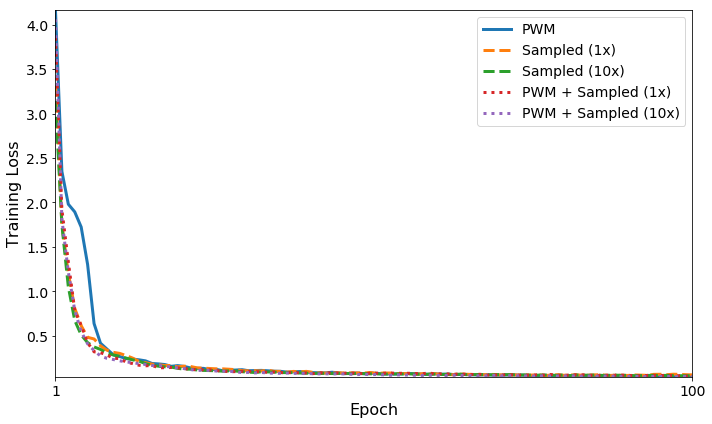

In [8]:

f = plt.figure(figsize=(10, 6))

summary_mode = 'median'
fig_suffix = "_" + str(n_epochs) + '_epochs_eval_pwm_vs_sample'

ls = []

min_y = 10000
max_y = 0

save_figs = True

for sampling_cond in sampling_conds :
    
    norm_prefix = ''
    if sampling_cond[2] == True :
        norm_prefix = '-IN'

    label = 'PWM' + norm_prefix
    linestyle = '-'
    if sampling_cond[0] == 'sample' :
        label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = '--'
    elif sampling_cond[0] == 'both' :
        label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = ':'
    
    train_hists = np.concatenate([np.array(sampling_cond[3]['train'][i]['loss']).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
    mean_train_hist = np.mean(train_hists, axis=-1) if summary_mode == 'mean' else np.median(train_hists, axis=-1)
                                                                                                
    l1 = plt.plot(np.arange(mean_train_hist.shape[0]), mean_train_hist, linewidth=3, linestyle=linestyle, label=label)
    ls.append(l1[0])
    
    if np.max(mean_train_hist) > max_y :
        max_y = np.max(mean_train_hist)
    
    if np.min(mean_train_hist) < min_y :
        min_y = np.min(mean_train_hist)

plt.xlim(0, n_epochs-1)
plt.xticks([0, n_epochs-1], [1, n_epochs], fontsize=14)

plt.ylim(min_y, max_y)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Training Loss", fontsize=16)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_training_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_training_' + summary_mode + fig_suffix + '.eps')
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_training_' + summary_mode + fig_suffix + '.svg')

plt.show()


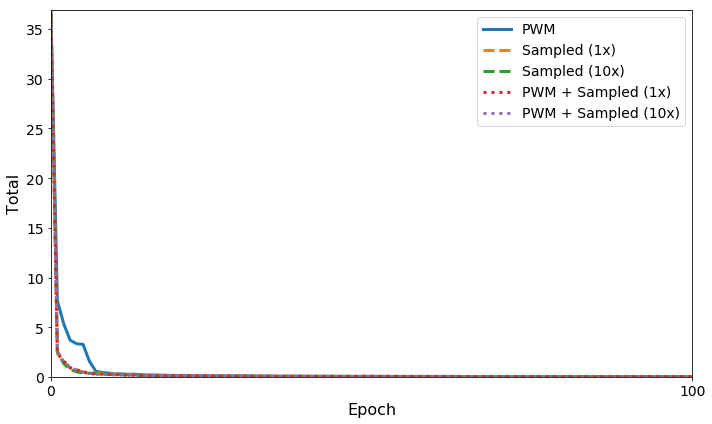

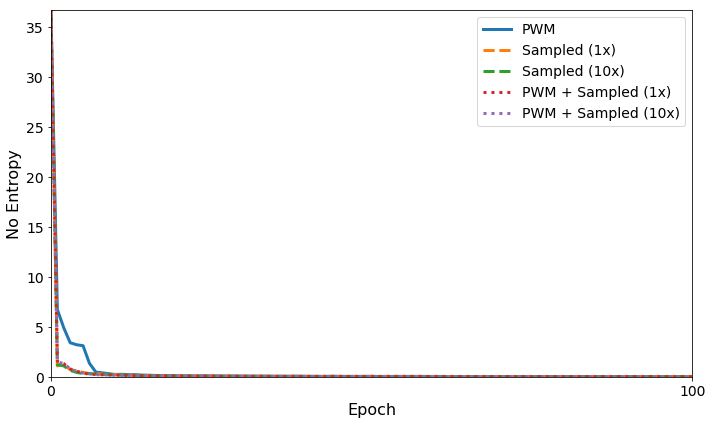

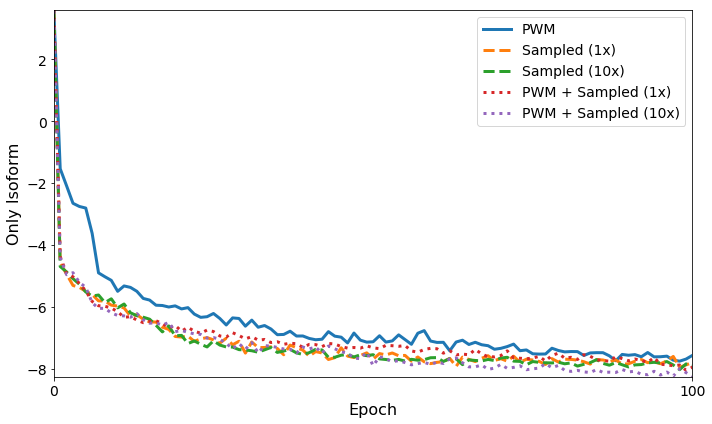

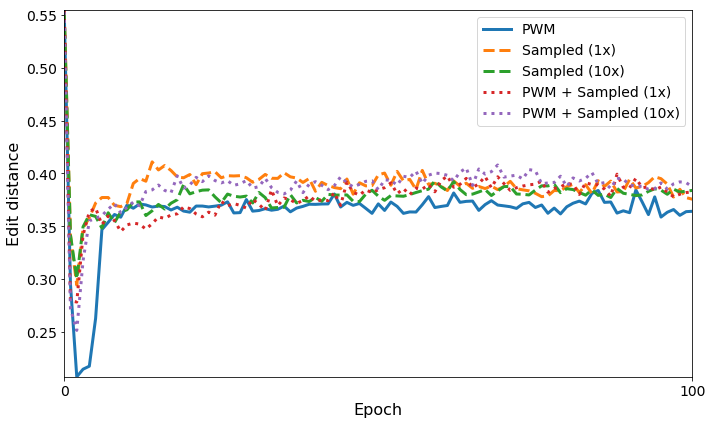

In [9]:

start_from_epoch = 0

summary_mode = 'median'
fig_suffix = "_" + str(n_epochs) + '_epochs_eval_pwm_vs_sample_from_epoch_' + str(start_from_epoch)

save_figs = True

for val_ix, val_name in enumerate(['Total', 'No Entropy', 'Only Isoform']) :

    f = plt.figure(figsize=(10, 6))

    ls = []

    min_y = 10000
    max_y = -10000

    for sampling_cond in sampling_conds :

        val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][val_ix]['val_loss_history'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
        mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)

        norm_prefix = ''
        if sampling_cond[2] == True :
            norm_prefix = '-IN'
        
        label = 'PWM' + norm_prefix
        linestyle = '-'
        if sampling_cond[0] == 'sample' :
            label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = '--'
        elif sampling_cond[0] == 'both' :
            label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = ':'

        l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
        ls.append(l1[0])

        if np.max(mean_val_hist[start_from_epoch:]) > max_y :
            max_y = np.max(mean_val_hist[start_from_epoch:])
        
        if np.min(mean_val_hist[start_from_epoch:]) < min_y :
            min_y = np.min(mean_val_hist[start_from_epoch:])

    plt.xlim(start_from_epoch, n_epochs)
    plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

    plt.ylim(min_y, max_y)
    plt.yticks(fontsize=14)

    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(val_name, fontsize=16)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()
    
    if save_figs :
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.eps')
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.svg')
    
    plt.show()


#Plot edit distance curves

opt_len = 90

f = plt.figure(figsize=(10, 6))

ls = []

min_y = 10000
max_y = -10000

for sampling_cond in sampling_conds :

    val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][3]['edit_distance_samples'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
    mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)
    if opt_len is not None :
        mean_val_hist /= opt_len
    
    norm_prefix = ''
    if sampling_cond[2] == True :
        norm_prefix = '-IN'

    label = 'PWM' + norm_prefix
    linestyle = '-'
    if sampling_cond[0] == 'sample' :
        label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = '--'
    elif sampling_cond[0] == 'both' :
        label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = ':'

    l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
    ls.append(l1[0])

    if np.max(mean_val_hist[start_from_epoch:]) > max_y :
        max_y = np.max(mean_val_hist[start_from_epoch:])

    if np.min(mean_val_hist[start_from_epoch:]) < min_y :
        min_y = np.min(mean_val_hist[start_from_epoch:])

plt.xlim(start_from_epoch, n_epochs)
plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

plt.ylim(min_y, max_y)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Edit distance", fontsize=16)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.eps')
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.svg')

plt.show()


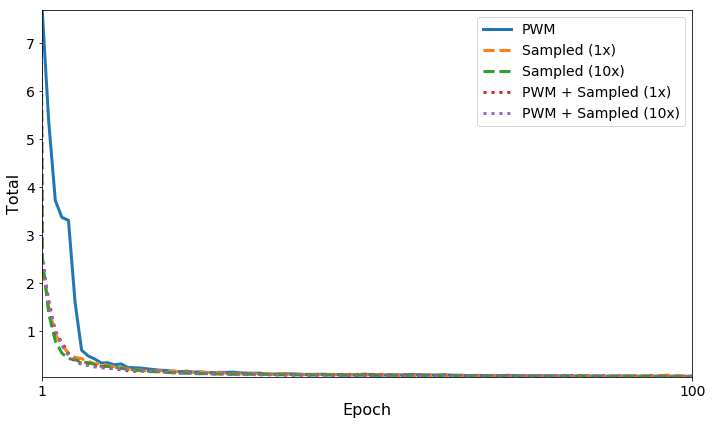

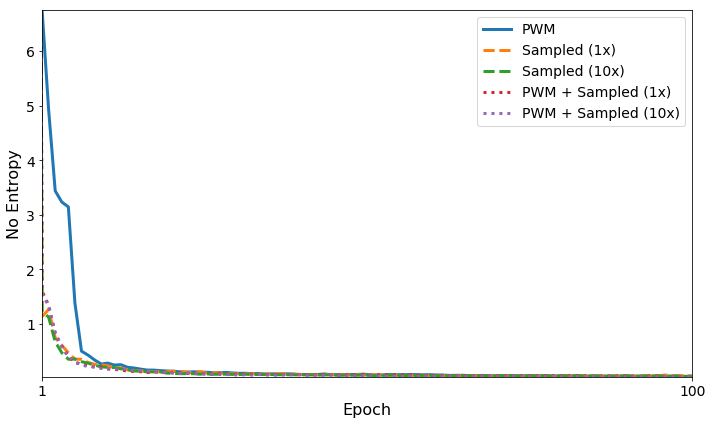

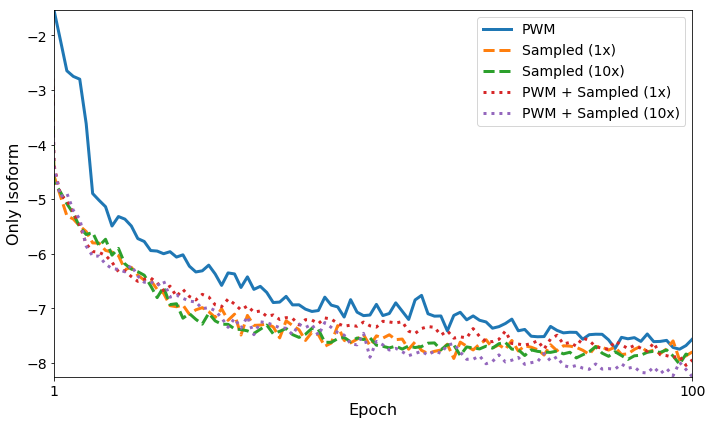

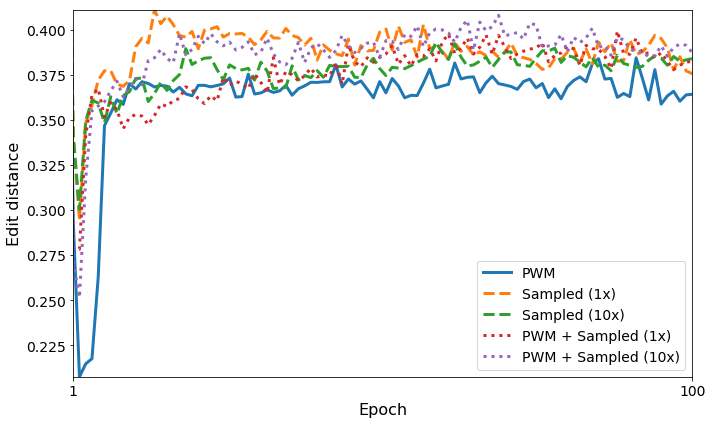

In [10]:

start_from_epoch = 1

summary_mode = 'median'
fig_suffix = "_" + str(n_epochs) + '_epochs_eval_pwm_vs_sample_from_epoch_' + str(start_from_epoch)

save_figs = True

for val_ix, val_name in enumerate(['Total', 'No Entropy', 'Only Isoform']) :

    f = plt.figure(figsize=(10, 6))

    ls = []

    min_y = 10000
    max_y = -10000

    for sampling_cond in sampling_conds :

        val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][val_ix]['val_loss_history'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
        mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)

        norm_prefix = ''
        if sampling_cond[2] == True :
            norm_prefix = '-IN'
        
        label = 'PWM' + norm_prefix
        linestyle = '-'
        if sampling_cond[0] == 'sample' :
            label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = '--'
        elif sampling_cond[0] == 'both' :
            label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = ':'

        l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
        ls.append(l1[0])

        if np.max(mean_val_hist[start_from_epoch:]) > max_y :
            max_y = np.max(mean_val_hist[start_from_epoch:])
        
        if np.min(mean_val_hist[start_from_epoch:]) < min_y :
            min_y = np.min(mean_val_hist[start_from_epoch:])

    plt.xlim(start_from_epoch, n_epochs)
    plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

    plt.ylim(min_y, max_y)
    plt.yticks(fontsize=14)

    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(val_name, fontsize=16)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()
    
    if save_figs :
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.eps')
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.svg')
    
    plt.show()


#Plot edit distance curves

opt_len = 90

f = plt.figure(figsize=(10, 6))

ls = []

min_y = 10000
max_y = -10000

for sampling_cond in sampling_conds :

    val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][3]['edit_distance_samples'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
    mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)
    if opt_len is not None :
        mean_val_hist /= opt_len
    
    norm_prefix = ''
    if sampling_cond[2] == True :
        norm_prefix = '-IN'

    label = 'PWM' + norm_prefix
    linestyle = '-'
    if sampling_cond[0] == 'sample' :
        label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = '--'
    elif sampling_cond[0] == 'both' :
        label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = ':'

    l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
    ls.append(l1[0])

    if np.max(mean_val_hist[start_from_epoch:]) > max_y :
        max_y = np.max(mean_val_hist[start_from_epoch:])

    if np.min(mean_val_hist[start_from_epoch:]) < min_y :
        min_y = np.min(mean_val_hist[start_from_epoch:])

plt.xlim(start_from_epoch, n_epochs)
plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

plt.ylim(min_y, max_y)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Edit distance", fontsize=16)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.eps')
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.svg')

plt.show()


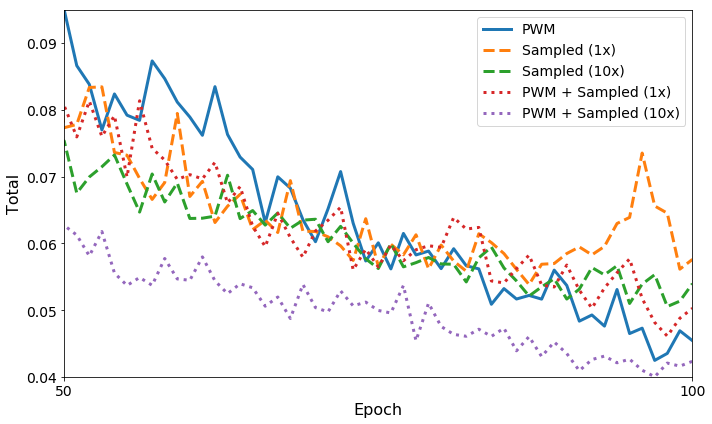

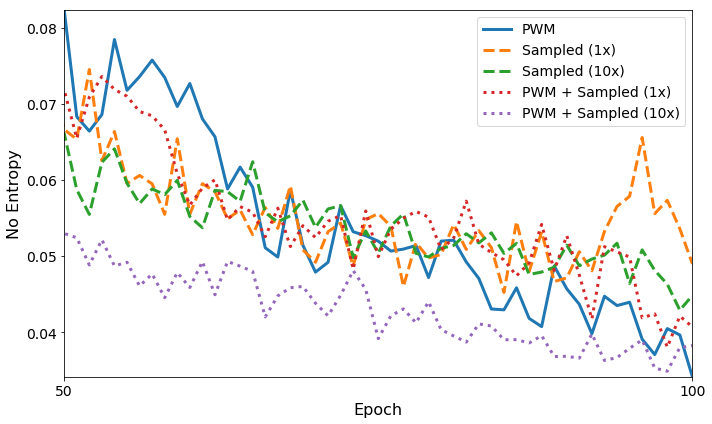

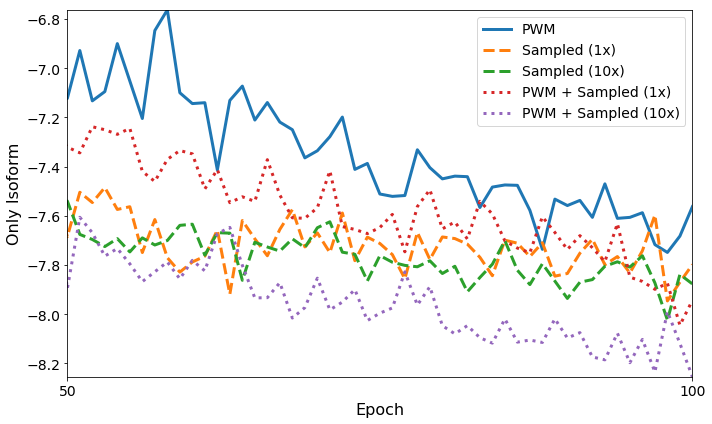

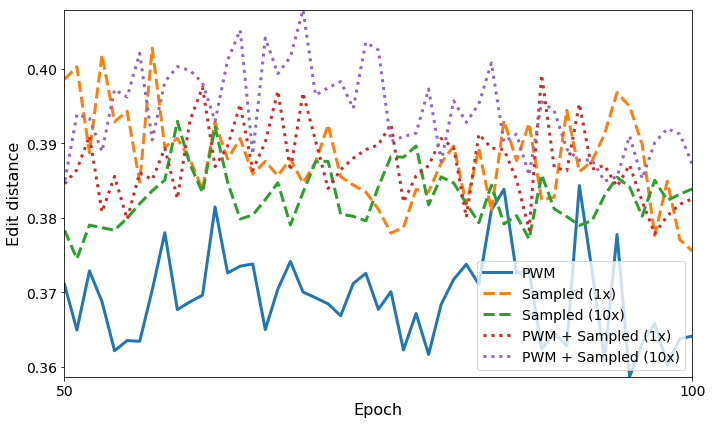

In [11]:

start_from_epoch = 50

summary_mode = 'median'
fig_suffix = "_" + str(n_epochs) + '_epochs_eval_pwm_vs_sample_from_epoch_' + str(start_from_epoch)

save_figs = True

for val_ix, val_name in enumerate(['Total', 'No Entropy', 'Only Isoform']) :

    f = plt.figure(figsize=(10, 6))

    ls = []

    min_y = 10000
    max_y = -10000

    for sampling_cond in sampling_conds :

        val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][val_ix]['val_loss_history'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
        mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)

        norm_prefix = ''
        if sampling_cond[2] == True :
            norm_prefix = '-IN'
        
        label = 'PWM' + norm_prefix
        linestyle = '-'
        if sampling_cond[0] == 'sample' :
            label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = '--'
        elif sampling_cond[0] == 'both' :
            label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = ':'

        l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
        ls.append(l1[0])

        if np.max(mean_val_hist[start_from_epoch:]) > max_y :
            max_y = np.max(mean_val_hist[start_from_epoch:])
        
        if np.min(mean_val_hist[start_from_epoch:]) < min_y :
            min_y = np.min(mean_val_hist[start_from_epoch:])

    plt.xlim(start_from_epoch, n_epochs)
    plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

    plt.ylim(min_y, max_y)
    plt.yticks(fontsize=14)

    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(val_name, fontsize=16)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()
    
    if save_figs :
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.eps')
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.svg')
    
    plt.show()


#Plot edit distance curves

opt_len = 90

f = plt.figure(figsize=(10, 6))

ls = []

min_y = 10000
max_y = -10000

for sampling_cond in sampling_conds :

    val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][3]['edit_distance_samples'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
    mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)
    if opt_len is not None :
        mean_val_hist /= opt_len
    
    norm_prefix = ''
    if sampling_cond[2] == True :
        norm_prefix = '-IN'

    label = 'PWM' + norm_prefix
    linestyle = '-'
    if sampling_cond[0] == 'sample' :
        label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = '--'
    elif sampling_cond[0] == 'both' :
        label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = ':'

    l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
    ls.append(l1[0])

    if np.max(mean_val_hist[start_from_epoch:]) > max_y :
        max_y = np.max(mean_val_hist[start_from_epoch:])

    if np.min(mean_val_hist[start_from_epoch:]) < min_y :
        min_y = np.min(mean_val_hist[start_from_epoch:])

plt.xlim(start_from_epoch, n_epochs)
plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

plt.ylim(min_y, max_y)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Edit distance", fontsize=16)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.eps')
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.svg')

plt.show()
